In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install deeplake torchmetrics segmentation_models_pytorch &> /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import deeplake
import time
import pickle
from torchvision.transforms.autoaugment import InterpolationMode
from torchvision import transforms
from segmentation_models_pytorch.losses import FocalLoss
from torchmetrics.classification import  BinarySpecificity, BinaryRecall, BinaryF1Score, BinaryAUROC, BinaryAccuracy
import numpy as np

In [4]:
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Tue Apr 25 01:52:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
dstrain = deeplake.load("hub://activeloop/drive-train")
dstest = deeplake.load("hub://activeloop/drive-test")

dataloader_train = dstrain.pytorch(num_workers=0, batch_size=1, shuffle=False)
dataloader_test = dstest.pytorch(num_workers=0, batch_size=1, shuffle=False)

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/drive-train



-

hub://activeloop/drive-train loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/drive-test



/

hub://activeloop/drive-test loaded successfully.



In [6]:
data = next(iter(dataloader_train))
img = data['rgb_images'][:,:,:-1,:]
img = transforms.Grayscale()(img.permute(0,3,1,2))
mask = torch.logical_not(data['manual_masks/mask'][0,:,:,0])[:,:-1]
# mask = torch.logical_not(torch.logical_xor(mask[0][:,:,0],mask[0][:,:,1])).long()
print(img.shape)
print(mask.shape)

torch.Size([1, 1, 584, 564])
torch.Size([584, 564])


In [7]:
# define an augmentation function
def augmentData(image,mask):
  # takes a batch of image, labels and returns a new batch comprising of original, rotated, flipped horizontal and center cropped images, and correpsonding labels
  # image (N,C,H,W)
  # mask (N,H,W)
  shape = (image.shape[2],image.shape[3])
  crop_percentage = 0.7
  cropped_shape = (int(shape[0]*crop_percentage),int(shape[1]*crop_percentage))
  flipped_h_img = transforms.RandomHorizontalFlip(1)(image)
  flipped_v_img = transforms.RandomVerticalFlip(1)(image)
  cropped_img = transforms.Resize(shape)(transforms.CenterCrop(cropped_shape)(image))
  x = torch.cat((image,flipped_h_img))
  x = torch.cat((x,flipped_v_img))
  x = torch.cat((x,cropped_img))

  flipped_h_mask = transforms.RandomHorizontalFlip(1)(mask)
  flipped_v_mask = transforms.RandomVerticalFlip(1)(mask)
  cropped_mask = transforms.Resize(shape,interpolation=InterpolationMode.NEAREST)(transforms.CenterCrop(cropped_shape)(mask))
  y = torch.cat((mask,flipped_h_mask))
  y = torch.cat((y,flipped_v_mask))
  y = torch.cat((y,cropped_mask))
  return x,y

def patches(img, kernel, stride, channels):
  # image (N,C,H,W)
  shape = (img.shape[2],img.shape[3])
  pad_h = stride - (584 - kernel) % stride
  pad_w = stride - (564 - kernel) % stride
  image = F.pad(img, (0, pad_w, 0, pad_h), "constant", 0)
  image = image[0].unfold(1, kernel, stride).unfold(2, kernel, stride).permute(1, 2, 0, 3, 4)
  image = image.contiguous().view(1,image.shape[0] * image.shape[1], image.shape[2], kernel, kernel)
  image = image.squeeze(0)
  image = transforms.Resize(shape,interpolation=InterpolationMode.NEAREST)(image)
  return image

In [8]:
# build train and val dataset
train_images = []
train_masks = []
for data in (dataloader_train):
  img = data['rgb_images'][:,:,:-1,:]
  img = transforms.Grayscale()(img.permute(0,3,1,2))
  mask = torch.logical_not(data['manual_masks/mask'][0,:,:,0])[:,:-1]
  train_images.append(img)
  train_masks.append(mask.unsqueeze(0).unsqueeze(0))

val_images = train_images[:6]
train_images = train_images[6:]
val_masks = train_masks[:6]
train_masks = train_masks[6:]

train_images = torch.concat(train_images,dim=0)
val_images = torch.concat(val_images,dim=0)
train_masks = torch.concat(train_masks,dim=0)
val_masks = torch.concat(val_masks,dim=0)

print('Train images shape : '+str(train_images.shape))
print('Val images shape : '+str(val_images.shape))
print('Train masks shape : '+str(train_masks.shape))
print('Val masks shape : '+str(val_masks.shape))

Train images shape : torch.Size([14, 1, 584, 564])
Val images shape : torch.Size([6, 1, 584, 564])
Train masks shape : torch.Size([14, 1, 584, 564])
Val masks shape : torch.Size([6, 1, 584, 564])


In [9]:
# augment training images and masks
img_aug,mask_aug = augmentData(train_images,train_masks)
print('Augmentation train images shape : '+str(img_aug.shape))
print('Augmentation train masks shape : '+str(mask_aug.shape))

Augmentation train images shape : torch.Size([56, 1, 584, 564])
Augmentation train masks shape : torch.Size([56, 1, 584, 564])


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


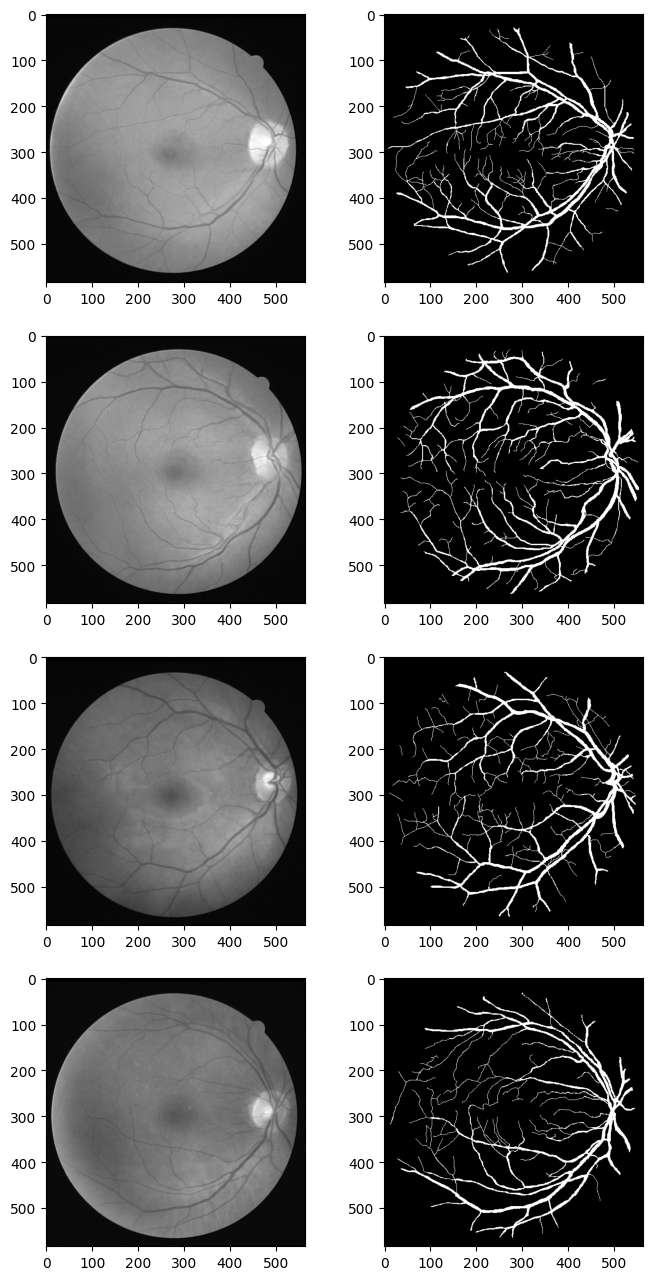

In [10]:
# visualize augmentations
plt.figure(figsize=(8,16))
for i in range(4):
  plt.subplot(4,2,2*i+1)
  plt.imshow(img_aug[i].permute(1,2,0),cmap='gray')
  plt.subplot(4,2,2*i+2)
  plt.imshow(mask_aug[i].permute(1,2,0),cmap='gray',vmin=0,vmax=1)
plt.show()

In [11]:
img_aug_patches = []
mask_aug_patches = []
for i in range(img_aug.shape[0]):
  img_aug_patches.append(patches(img_aug[i].unsqueeze(0),250,100,1))
  mask_aug_patches.append(patches(mask_aug[i].unsqueeze(0),250,100,1))
img_aug_patches = torch.concat(img_aug_patches,dim=0)
mask_aug_patches = torch.concat(mask_aug_patches, dim=0)
print('Train Patch images shape : '+str(img_aug_patches.shape))
print('Train Patch masks shape : '+str(mask_aug_patches.shape))


Train Patch images shape : torch.Size([1400, 1, 584, 564])
Train Patch masks shape : torch.Size([1400, 1, 584, 564])


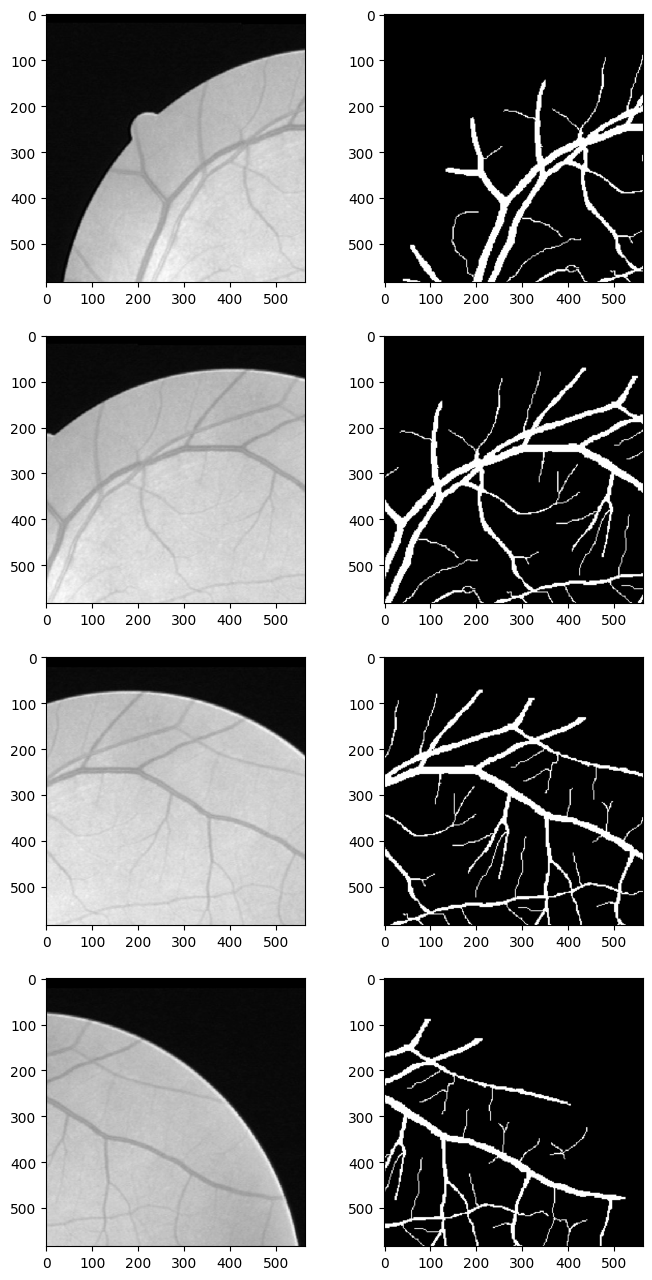

In [12]:
# visualize patches
plt.figure(figsize=(8,16))
for i in range(4):
  plt.subplot(4,2,2*i+1)
  plt.imshow(img_aug_patches[i+500].permute(1,2,0),cmap='gray')
  plt.subplot(4,2,2*i+2)
  plt.imshow(mask_aug_patches[i+500].permute(1,2,0),cmap='gray',vmin=0,vmax=1)
plt.show()

In [13]:
class FeatureAggregationModule(nn.Module):
   def __init__(self, inch,outch):
     super(FeatureAggregationModule,self).__init__()
     self.conv1 = nn.Conv2d(inch, outch, kernel_size=1, padding =0, bias=False)
     self.conv2 = nn.Conv2d(inch, outch, kernel_size=3, padding =1, bias=False)
     self.conv3 = nn.Conv2d(inch, outch, kernel_size=3, padding =2, dilation=2,bias=False)
     self.norm = nn.BatchNorm2d(outch)

   def forward(self, x):
     x1 = self.conv1(x)
     x2 = self.conv2(x)
     x3 = self.conv3(x)
     x = self.norm(x1+x2+x3)
     return x  

class ModifiedResidualBlock(nn.Module):
    def __init__(self, inch, outch):
      super(ModifiedResidualBlock,self).__init__()
      self.conv1 = nn.Conv2d(inch, outch, kernel_size=3,padding=1,bias=False)
      self.batch = nn.BatchNorm2d(outch)
      self.drop1 = nn.Dropout2d(0.2)
      self.relu1 = nn.LeakyReLU(0.02,inplace=True)
      self.conv2 = nn.Conv2d(outch, outch, kernel_size=3,padding=1,bias=False)
      self.batch2 = nn.BatchNorm2d(outch)
      self.drop2 = nn.Dropout2d(0.2)
      self.leakyrelu = nn.LeakyReLU(0.02,inplace=True)
      if inch != outch:
            self.conv3 = nn.Conv2d(inch, outch, kernel_size=1, padding=0)
      else:
            self.conv3 = None  
    
    def forward(self, x):        
      xi = self.conv1(x)
      x1 = self.batch(xi)
      x1 = self.drop1(x1)
      x1 = self.relu1(x1)
      x1 = self.conv2(x1)
      x1 = self.batch2(x1)
      x1 = self.drop2(x1)
      if self.conv3 is not None:
          x = self.conv3(x)
      x1 = self.leakyrelu(x1+x)

      return x1

class Upsample(nn.Module):
  def __init__(self, inch, outch):
    super(Upsample,self).__init__()
    self.conv1 = nn.ConvTranspose2d(inch,outch,kernel_size =2,padding =0, stride =2, bias=False)
    self.batch = nn.BatchNorm2d(outch)
    self.relu = nn.LeakyReLU(0.1,inplace=True)
  
  def forward(self,x):
    x1 = self.conv1(x)
    x1 = self.batch(x1)
    x1 = self.relu(x1)

    return x1  
    
class Downsample(nn.Module):
  def __init__(self, inch, outch):
    super(Downsample,self).__init__()
    self.conv1 = nn.Conv2d(inch,outch,kernel_size =2,padding =0, stride =2, bias=False)
    self.batch = nn.BatchNorm2d(outch)
    self.relu = nn.LeakyReLU(0.1,inplace=True)

  def forward(self,x):
    x1 = self.conv1(x)
    x1 = self.batch(x1)
    x1 = self.relu(x1)
    return x1   

class DeepBlock(nn.Module):
    def __init__(self,inch, outch ):
        super(DeepBlock, self).__init__()
        self.fam =  FeatureAggregationModule(inch, outch)
        self.mod = ModifiedResidualBlock(outch, outch)
        
    def forward(self,x):
        x1 = self.fam(x)
        x1 = self.mod(x1)
        return x1

class SpatialAttn(nn.Module):
  def __init__(self):
    super(SpatialAttn, self).__init__()
    self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=(7-1)//2, bias=False)

  def forward(self, x):
    avg_pool_output = torch.mean(x, dim=1)
    max_pool_output, _ = torch.max(x, dim=1)
    concat_output = torch.cat((avg_pool_output.unsqueeze(1), max_pool_output.unsqueeze(1)), dim=1)
    output = self.conv(concat_output)
    output = torch.sigmoid(output)
    output_ftrs = x * output
    return output_ftrs
        
class FRUNet(nn.Module):
  def __init__(self):
    super(FRUNet, self).__init__()
    self.mod11 = ModifiedResidualBlock(1, 32)
    self.mod12 = ModifiedResidualBlock(32, 32)
    self.db11 = DeepBlock(32*2,32)
    self.db12  = DeepBlock(32*2 ,32)
    self.db13 = DeepBlock(32*2, 32)
    self.db14 = DeepBlock(32*2, 32)
    self.db15 = DeepBlock(32*2,32)
    self.conv = nn.Conv2d(32, 1, kernel_size=1, stride=1,bias=True)
    self.down11 = Downsample(32, 64)
    self.up11 = Upsample(64, 32)
    self.down12 =Downsample(32, 64)
    self.up12 = Upsample(64, 32)
    self.down13 =Downsample(32, 64)
    self.up13 = Upsample(64, 32)
    self.down14 =Downsample(32, 64)
    self.up14 = Upsample(64, 32)
    self.down15 = Downsample(32, 64)
    self.up15 = Upsample(64, 32)
    self.layer21 = ModifiedResidualBlock(64, 64)
    self.db21 = DeepBlock(64*2,64)
    self.db22 = DeepBlock(64*3, 64)
    self.db23 = DeepBlock(64*3, 64)
    self.db24 = DeepBlock(64*3, 64)
    self.down21 = Downsample(64, 128)
    self.up21 = Upsample(128, 64)
    self.down22 =Downsample(64, 128)
    self.up22 = Upsample(128, 64)
    self.down23 =Downsample(64, 128)
    self.up23 = Upsample(128, 64)
    self.layer31 = ModifiedResidualBlock(128, 128)
    self.db31 = DeepBlock(128*2, 128)
    self.db32 = DeepBlock(128*3, 128)
    self.down31 = Downsample(128, 256)
    self.up31 = Upsample(256, 128)
    self.final = SpatialAttn()

  def forward(self,x):
    out11 = self.mod11(x)
    out12 = self.mod12(out11)
    out21 = self.layer21(self.down11(out11))
    out31 = self.layer31(self.down21(out21))
    out41 = self.down31(out31)
    out42 = self.final(out41)
    out43 = self.up31(out42)
    res1 = self.db11(torch.cat((out12,self.up11(out21)),dim=1))
    out22 = self.db21(torch.cat((self.down12(out12),out21),dim=1))
    res2 = self.db12(torch.cat((res1,self.up12(out22)),dim=1))
    out23 = self.db22(torch.cat((self.down13(res1),out22,self.up21(out31)),dim=1))
    res3 = self.db13(torch.cat((res2,self.up13(out23)),dim=1))
    out32 = self.db31(torch.cat((out31,self.down22(out22)),dim=1))
    out24 = self.db23(torch.cat((self.down14(res2),out23,self.up22(out32)),dim=1))
    res4 = self.db14(torch.cat((res3,self.up14(out24)),dim=1))
    out33 = self.db32(torch.cat((out32,self.down23(out23),torch.cat((out43,torch.ones(1,128,146,1).to(device)),3)),dim=1))
    out25 = self.db24(torch.cat((self.down15(res3),out24,self.up23(out33)),dim=1))
    res5 = self.db15(torch.cat((res4,self.up15(out25)),dim=1))

    res = 0.2*self.conv(res1) + 0.2*self.conv(res2) + 0.2*self.conv(res3) + 0.2*self.conv(res4) + 0.2*self.conv(res5)
    res = torch.sigmoid(res)
    return res

In [14]:
def DTI(segMap, high_th, low_th):
    n, h, w = segMap.shape
    # Computing the probability map and scaling the values by 255 for efficient processing
    probMap = (segMap*255).type(torch.uint8)
    high_th *= 255
    low_th *= 255
    bMap = torch.where(probMap >= high_th, 255, 0).type(torch.uint8)
    gMap = bMap.clone()
    gMap_pre = gMap-1
    while((gMap_pre != gMap).all()):
        gMap_pre = gMap
        for k in range(n):
          for i in range(h-1):
              for j in range(w-1):
                  if gMap[k,i,j] == 0 and probMap[k,i,j] < high_th and probMap[k,i,j] >= low_th:
                      if gMap[k,i-1,j-1] or gMap[k,i-1,j] or gMap[k,i,j-1] or gMap[k,i-1,j+1] or gMap[k,i,j+1] or gMap[k,i+1,j-1] or gMap[k,i+1,j] or gMap[k,i+1,j+1]:
                          gMap[k,i,j] = 255
    return gMap/255

In [15]:
net = FRUNet().to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = FocalLoss('binary')

optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience =2,factor=0.01, threshold=1e-15, verbose=True)
epochs = 10

In [16]:
auroc = BinaryAUROC().to(device)
f1 = BinaryF1Score().to(device)
spec = BinarySpecificity().to(device)
sen = BinaryRecall().to(device)
acc = BinaryAccuracy().to(device)

In [17]:
train_loss = []
train_spec = []
train_sen = []
train_aucroc = []
train_f1 = []
train_acc = []

val_loss = []
val_spec = []
val_sen = []
val_aucroc = []
val_f1 = []
val_acc = []

print('Training started.....')
for epoch in range(epochs):
    start_time = time.time()
    tr_loss,tr_acc, tr_aucroc, tr_f1, tr_spec, tr_sen = 0,0,0,0,0,0
    v_loss,v_acc, v_aucroc, v_f1, v_spec, v_sen = 0,0,0,0,0,0
    
    num_batches = 0
    print('[Epoch {}]'.format(epoch+1))
    for img,mask in zip(img_aug_patches,mask_aug_patches): 
        img = img.float()/255
        img = img.to(device)
        mask = mask.float().to(device)
        optimizer.zero_grad()
        outputs = net(img.unsqueeze(0))
        loss = criterion(outputs, mask.unsqueeze(0))
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()

        outputs = (outputs >0.5).int()        
        # outputs = DTI(outputs.squeeze(1), 0.5, 0.3).unsqueeze(1).int() 
        tr_acc += acc(outputs[0], mask.int()) 
        tr_f1 += f1(outputs[0], mask.int())
        tr_spec += spec(outputs[0], mask.int())
        tr_sen += sen(outputs[0], mask.int())
        tr_aucroc += auroc(outputs[0], mask.int())
        num_batches +=1
    train_loss.append(tr_loss/num_batches)
    train_acc.append(tr_acc/ num_batches)
    train_spec.append(tr_spec/num_batches)
    train_sen.append(tr_sen/num_batches)
    train_f1.append(tr_f1/num_batches)
    train_aucroc.append(tr_aucroc/num_batches)

    # validation step
    with torch.no_grad():
      num_batches = 0
      for img,mask in zip(val_images,val_masks):
        img = img.float()/255
        img = img.to(device)
        mask = mask.float().to(device)
        outputs = net(img.unsqueeze(0))
        loss = criterion(outputs,mask.unsqueeze(0))
        v_loss += loss.item()
        outputs = (outputs>0.5).int()
        v_acc += acc(outputs[0], mask.int()) 
        v_f1 += f1(outputs[0], mask.int())
        v_spec += spec(outputs[0], mask.int())
        v_sen += sen(outputs[0], mask.int())
        v_aucroc += auroc(outputs[0], mask.int())
        num_batches+=1
      val_loss.append(v_loss/num_batches)
      val_acc.append(v_acc/ num_batches)
      val_spec.append(v_spec/num_batches)
      val_sen.append(v_sen/num_batches)
      val_f1.append(v_f1/num_batches)
      val_aucroc.append(v_aucroc/num_batches)



    print('train_loss: {:.8f} train_acc: {:.4f} train_f1: {:.4f} train_sen: {:.4f} train_spec: {:.4f} train_auroc: {:.4f}'.format(train_loss[-1],train_acc[-1],train_f1[-1],train_sen[-1],train_spec[-1],train_aucroc[-1]))
    print('val_loss: {:.8f} val_acc: {:.4f} val_f1: {:.4f} val_sen: {:.4f} val_spec: {:.4f} val_auroc: {:.4f}'.format(val_loss[-1],val_acc[-1],val_f1[-1],val_sen[-1],val_spec[-1],val_aucroc[-1]))
    scheduler.step(val_loss[-1])
    end_time = time.time()
    print('Time taken:{:.4f} minutes'.format((end_time - start_time)/60))
    pickle.dump(net, open(f'/gdrive/MyDrive/Colab Notebooks/DL/Project/Saved Models/FRUNet_SA_{epoch+1}.pkl', 'wb'))

Training started.....
[Epoch 1]
train_loss: 0.21508117 train_acc: 0.9204 train_f1: 0.4864 train_sen: 0.3813 train_spec: 0.9799 train_auroc: 0.6806
val_loss: 0.18703805 val_acc: 0.9190 val_f1: 0.3187 val_sen: 0.2156 val_spec: 0.9870 val_auroc: 0.6013
Time taken:15.6229 minutes
[Epoch 2]
train_loss: 0.17429779 train_acc: 0.9407 train_f1: 0.5798 train_sen: 0.4348 train_spec: 0.9962 train_auroc: 0.7155
val_loss: 0.17773201 val_acc: 0.9208 val_f1: 0.2893 val_sen: 0.1861 val_spec: 0.9916 val_auroc: 0.5889
Time taken:15.5247 minutes
[Epoch 3]


OutOfMemoryError: ignored

In [17]:
net = pickle.load(open('/gdrive/MyDrive/Colab Notebooks/DL/Project/Saved Models/FRUNet_SA_2.pkl','rb'))

In [18]:
for epoch in range(2, epochs):
    start_time = time.time()
    tr_loss,tr_acc, tr_aucroc, tr_f1, tr_spec, tr_sen = 0,0,0,0,0,0
    v_loss,v_acc, v_aucroc, v_f1, v_spec, v_sen = 0,0,0,0,0,0
    
    num_batches = 0
    print('[Epoch {}]'.format(epoch+1))
    for img,mask in zip(img_aug_patches,mask_aug_patches): 
        img = img.float()/255
        img = img.to(device)
        mask = mask.float().to(device)
        optimizer.zero_grad()
        outputs = net(img.unsqueeze(0))
        loss = criterion(outputs, mask.unsqueeze(0))
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()

        outputs = (outputs >0.5).int()        
        # outputs = DTI(outputs.squeeze(1), 0.5, 0.3).unsqueeze(1).int() 
        tr_acc += acc(outputs[0], mask.int()) 
        tr_f1 += f1(outputs[0], mask.int())
        tr_spec += spec(outputs[0], mask.int())
        tr_sen += sen(outputs[0], mask.int())
        tr_aucroc += auroc(outputs[0], mask.int())
        num_batches +=1
    train_loss.append(tr_loss/num_batches)
    train_acc.append(tr_acc/ num_batches)
    train_spec.append(tr_spec/num_batches)
    train_sen.append(tr_sen/num_batches)
    train_f1.append(tr_f1/num_batches)
    train_aucroc.append(tr_aucroc/num_batches)

    # validation step
    with torch.no_grad():
      num_batches = 0
      for img,mask in zip(val_images,val_masks):
        img = img.float()/255
        img = img.to(device)
        mask = mask.float().to(device)
        outputs = net(img.unsqueeze(0))
        loss = criterion(outputs,mask.unsqueeze(0))
        v_loss += loss.item()
        outputs = (outputs>0.5).int()
        v_acc += acc(outputs[0], mask.int()) 
        v_f1 += f1(outputs[0], mask.int())
        v_spec += spec(outputs[0], mask.int())
        v_sen += sen(outputs[0], mask.int())
        v_aucroc += auroc(outputs[0], mask.int())
        num_batches+=1
      val_loss.append(v_loss/num_batches)
      val_acc.append(v_acc/ num_batches)
      val_spec.append(v_spec/num_batches)
      val_sen.append(v_sen/num_batches)
      val_f1.append(v_f1/num_batches)
      val_aucroc.append(v_aucroc/num_batches)



    print('train_loss: {:.8f} train_acc: {:.4f} train_f1: {:.4f} train_sen: {:.4f} train_spec: {:.4f} train_auroc: {:.4f}'.format(train_loss[-1],train_acc[-1],train_f1[-1],train_sen[-1],train_spec[-1],train_aucroc[-1]))
    print('val_loss: {:.8f} val_acc: {:.4f} val_f1: {:.4f} val_sen: {:.4f} val_spec: {:.4f} val_auroc: {:.4f}'.format(val_loss[-1],val_acc[-1],val_f1[-1],val_sen[-1],val_spec[-1],val_aucroc[-1]))
    scheduler.step(val_loss[-1])
    end_time = time.time()
    print('Time taken:{:.4f} minutes'.format((end_time - start_time)/60))
    print()
    pickle.dump(net, open(f'/gdrive/MyDrive/Colab Notebooks/DL/Project/Saved Models/FRUNet_SA_{epoch+1}.pkl', 'wb'))

[Epoch 3]


NameError: ignored

In [21]:
# build test dataset
test_images = []
test_masks = []
for data in (dataloader_test):
  img = data['rgb_images'][:,:,:-1,:]
  img = transforms.Grayscale()(img.permute(0,3,1,2))
  mask = torch.logical_not(data['masks'][0,:,:,0])[:,:-1]
  test_images.append(img)
  test_masks.append(mask.unsqueeze(0).unsqueeze(0))

test_images = torch.concat(test_images,dim=0)
test_masks = torch.concat(test_masks,dim=0)


print('Test images shape : '+str(test_images.shape))
print('Test masks shape : '+str(test_masks.shape))


Test images shape : torch.Size([20, 1, 584, 564])
Test masks shape : torch.Size([20, 1, 584, 564])


In [22]:
net = pickle.load(open('/gdrive/MyDrive/Colab Notebooks/DL/Project/Saved Models/FRUNet_SA_2.pkl','rb'))

In [23]:
# Test set analysis
test_spec = 0
test_sen = 0
test_aucroc = 0
test_f1 = 0
test_acc = 0

with torch.no_grad():
  t_acc, t_aucroc, t_f1, t_spec, t_sen = 0,0,0,0,0
  num_batches = 0
  for img,mask in zip(test_images,test_masks):
    img = img.float()/255
    img = img.to(device)
    mask = mask.float().to(device)
    outputs = net(img.unsqueeze(0))
    outputs = (outputs>0.5).int()
    t_acc += acc(outputs[0], mask.int()) 
    t_f1 += f1(outputs[0], mask.int())
    t_spec += spec(outputs[0], mask.int())
    t_sen += sen(outputs[0], mask.int())
    t_aucroc += auroc(outputs[0], mask.int())
    num_batches+=1
  test_acc = t_acc/ num_batches
  test_spec = t_spec/num_batches
  test_sen = t_sen/num_batches
  test_f1 = t_f1/num_batches
  test_aucroc = t_aucroc/num_batches

print('---- Test Set Results ----')
print('Accuracy : {:.4f}'.format(test_acc))
print('Sensitivity : {:.4f}'.format(test_sen))
print('Specificity : {:.4f}'.format(test_spec))
print('F1 Score : {:.4f}'.format(test_f1))
print('AUCROC Score : {:.4f}'.format(test_aucroc))

---- Test Set Results ----
Accuracy : 0.3259
Sensitivity : 0.0296
Specificity : 0.9821
F1 Score : 0.0570
AUCROC Score : 0.5059
